In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:18
🔁 Restarting kernel...


In [ ]:
%%time
!conda install alignn chgnet matgl pytorch torchvision torchaudio pytorch-cuda -c pytorch -c nvidia -y --quiet

Channels:
 - pytorch
 - nvidia
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - alignn
    - chgnet
    - matgl
    - pytorch
    - pytorch-cuda
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |       2_kmp_llvm           6 KB  conda-forge
    absl-py-2.1.0              |     pyhd8ed1ab_0         105 KB  conda-forge
    alignn-2024.5.27           |     pyhd8ed1ab_0          72 KB  conda-forge
    annotated-types-0.7.0      |     pyhd8ed1ab_0          18 KB  conda-forge
    ase-3.23.0                 |     pyhd8ed1ab_0         1.8 MB  conda-forge
    astunparse-1.6.3           |     pyhd8ed1ab_0          15 KB  conda-forge
    babel-2.14.0               |     pyhd8ed1ab_0         7.3 MB  conda-forge
    blinker-1.8

In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.2.post104
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!git clone https://github.com/ACEsuit/mace.git

fatal: destination path 'mace' already exists and is not an empty directory.


In [4]:
pip install ./mace

Processing ./mace
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mace-torch: filename=mace_torch-0.3.6-py3-none-any.whl size=114647 sha256=64176ad314fbd2579b531dd013dafb13a6e4cf3c54552e1c8d96b321a7f318dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-mk1z7pnv/wheels/df/5f/32/ef59561725170a81c728fd01c75e56a9ee83bad6da485fc6a5
Successfully built mace-torch
  Attempting uninstall: mace-torch
    Found existing installation: mace-torch 0.3.6
    Uninstalling mace-torch-0.3.6:
      Successfully uninstalled mace-torch-0.3.6


In [5]:
!git clone https://github.com/MDIL-SNU/SevenNet.git

Cloning into 'SevenNet'...
remote: Enumerating objects: 2355, done.
remote: Counting objects: 100% (930/930), done.
remote: Compressing objects: 100% (462/462), done.
remote: Total 2355 (delta 565), reused 698 (delta 456), pack-reused 1425
Receiving objects: 100% (2355/2355), 87.48 MiB | 15.41 MiB/s, done.
Resolving deltas: 100% (1603/1603), done.


In [6]:
pip install ./SevenNet/

Processing ./SevenNet
  Preparing metadata (setup.py) ... done
  Created wheel for sevenn: filename=sevenn-0.9.2-py3-none-any.whl size=79585 sha256=bbe1d454bda66f022ec5743c58b27b43997dbe56494458a2c221c314431a6155
  Stored in directory: /tmp/pip-ephem-wheel-cache-k72bych5/wheels/c7/ca/8c/848f15d66e19fafdb6ec945b9b0b83cf4d16d5541201fc709a
Successfully built sevenn


In [7]:
pip install phonopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 23.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for phonopy: filename=phonopy-2.26.6-cp310-cp310-linux_x86_64.whl size=498282 sha256=f08f2a07db981e7f7ff26b59e87b2ca38ff1eb4e3578f6a549f95e6ff98019cd
  Stored in directory: /root/.cache/pip/wheels/f4/ed/06/0176a42c0a6748ca0710e307e749d6d94b8baf3bc9d2f547a1
Successfully built phonopy


In [8]:
!conda install -c conda-forge phono3py

Channels:
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: / - \ | / - \ | / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - phono3py


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openblas-0.3.27            |pthreads_h9eca1d5_1         5.5 MB  conda-forge
    phono3py-3.3.2             |  py310hfc14280_0         3.1 MB  conda-forge
    phonopy-2.26.6             |  py310h27b3328_0         1.6 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        10.2 MB

The following NEW packages will be INSTALLED

In [9]:
!pip install -q git+https://github.com/usnistgov/intermat.git@develop

  Preparing metadata (setup.py) ... done


In [10]:
!pip install -q elastic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 627.0/627.0 kB 6.7 MB/s eta 0:00:00


In [2]:
import alignn
import matgl
import chgnet
import mace
import sevenn

In [3]:
from jarvis.db.figshare import data, get_jid_data
from jarvis.core.atoms import Atoms
from jarvis.io.vasp.inputs import Poscar
indices_list = [[1, 0, 0],[1, 1, 1],[1,1,0],[0,1,1],[0,0,1],[0,1,0]]
def get_atoms(jid):
    dat = get_jid_data(jid=jid, dataset="dft_3d")
    return Atoms.from_dict(dat["atoms"])

In [4]:
from ase.optimize.fire import FIRE
from ase.constraints import ExpCellFilter
from jarvis.core.atoms import ase_to_atoms
from matgl.ext.ase import M3GNetCalculator
from sevenn.sevennet_calculator import SevenNetCalculator
from alignn.ff.ff import AlignnAtomwiseCalculator, default_path
from chgnet.model.dynamics import CHGNetCalculator
model_filename='best_model.pt'
from mace.calculators import mace_mp

def setup_calculator(calculator_type):
    if calculator_type == "matgl":
        pot = matgl.load_model("M3GNet-MP-2021.2.8-PES")
        return M3GNetCalculator(pot)
    elif calculator_type == "alignn_ff":
        model_path = default_path()
        return AlignnAtomwiseCalculator(path=model_path,stress_wt=0.3,force_mult_natoms=False,force_multiplier=1,modl_filename=model_filename)
    elif calculator_type == "chgnet":
        return CHGNetCalculator()
    elif calculator_type == "mace":
        return mace_mp()
    elif calculator_type == "sevennet":
        checkpoint_path = "SevenNet/pretrained_potentials/SevenNet_0__11July2024/checkpoint_sevennet_0.pth"
        sevenet_cal = SevenNetCalculator(checkpoint_path, device='cpu')
        return sevenet_cal
    else:
        raise ValueError("Unsupported calculator type")


In [5]:
import io
import contextlib
import re
def capture_fire_output(ase_atoms, fmax, steps):
    log_stream = io.StringIO()
    with contextlib.redirect_stdout(log_stream):
        dyn = FIRE(ase_atoms)
        dyn.run(fmax=fmax, steps=steps)
    output = log_stream.getvalue().strip()
    final_energy = None
    if output:
        last_line = output.split('\n')[-1]
        match = re.search(r'FIRE:\s+\d+\s+\d+:\d+:\d+\s+(-?\d+\.\d+)', last_line)
        if match:
            final_energy = float(match.group(1))
    return final_energy, dyn.nsteps

In [6]:
def relax_structure(atoms, calculator_type, fmax=0.05, steps=200, log_file=None, job_info=None):
    ase_atoms = atoms.ase_converter()
    calc = setup_calculator(calculator_type)
    ase_atoms.calc = calc
    ase_atoms = ExpCellFilter(ase_atoms)
    final_energy, nsteps = capture_fire_output(ase_atoms, fmax, steps)
    relaxed_atoms = ase_to_atoms(ase_atoms.atoms)
    converged = nsteps < steps
    if log_file:
        log_job_info(f"Final energy of FIRE optimization for structure: {final_energy}", log_file)
        log_job_info(f"Relaxation {'converged' if converged else 'did not converge'} within {steps} steps.", log_file)
    if job_info is not None:
        job_info["final_energy_structure"] = final_energy
        job_info["converged"] = converged
    return relaxed_atoms


In [7]:
import numpy as np
from ase.eos import EquationOfState
from ase.units import kJ
import matplotlib.pyplot as plt

def ev_curve(
    atoms=None,
    dx=np.arange(-0.05, 0.05, 0.01),
    calculator=None,
    on_relaxed_struct=False,
    stress_wt=1,
):
    """Get EV curve."""
    relaxed = atoms

    y = []
    vol = []
    for i in dx:
        s1 = relaxed.strain_atoms(i)
        ase_atoms = s1.ase_converter()
        ase_atoms.calc = calculator
        energy = ase_atoms.get_potential_energy()
        y.append(energy)
        vol.append(s1.volume)
    x = np.array(dx)
    y = np.array(y)
    eos = EquationOfState(vol, y, eos="murnaghan")
    v0, e0, B = eos.fit()
    kv = B / kJ * 1.0e24  # , 'GPa')
    print("Energies:", y)
    print("Volumes:", vol)
    return x, y, eos, kv

def calculate_ev_curve(atoms, calculator, dx=np.arange(-0.06, 0.06, 0.01)):
    x, y, eos, kv = ev_curve(atoms=atoms, dx=dx, calculator=calculator)
    v0, e0 = eos.v0, eos.e0  # Equilibrium volume and energy
    return x, y, eos, kv, e0, v0



In [8]:
import numpy as np
from phonopy import Phonopy
from phonopy.file_IO import write_FORCE_CONSTANTS
from jarvis.core.kpoints import Kpoints3D as Kpoints
from ase import Atoms as AseAtoms

def phonons_gen(
    atoms=None,
    calculator=None,
    dim=[2, 2, 2],
    freq_conversion_factor=33.3566830,  # Thz to cm-1
    phonopy_bands_figname="phonopy_bands.png",
    write_fc=False,
    min_freq_tol=-0.05,
    distance=0.2,
):
    """Make Phonon calculation setup."""
    if atoms is None or calculator is None:
        raise ValueError("Atoms and calculator must be provided")

    kpoints = Kpoints().kpath(atoms, line_density=5)
    bulk = atoms.phonopy_converter()
    phonon = Phonopy(bulk, [[dim[0], 0, 0], [0, dim[1], 0], [0, 0, dim[2]]])
    phonon.generate_displacements(distance=distance)
    supercells = phonon.get_supercells_with_displacements()
    set_of_forces = []
    for scell in supercells:
        ase_atoms = AseAtoms(
            symbols=scell.symbols,
            positions=scell.positions,
            cell=scell.cell,
            pbc=True,
        )
        ase_atoms.calc = calculator
        forces = np.array(ase_atoms.get_forces())
        drift_force = forces.sum(axis=0)
        for force in forces:
            force -= drift_force / forces.shape[0]
        set_of_forces.append(forces)

    phonon.produce_force_constants(forces=set_of_forces)
    if write_fc:
        write_FORCE_CONSTANTS(
            phonon.get_force_constants(), filename="FORCE_CONSTANTS"
        )

    lbls = kpoints.labels
    lbls_ticks = []
    freqs = []
    tmp_kp = []
    lbls_x = []
    count = 0
    for ii, k in enumerate(kpoints.kpts):
        k_str = ",".join(map(str, k))
        if ii == 0:
            tmp = []
            for i, freq in enumerate(phonon.get_frequencies(k)):
                tmp.append(freq)
            freqs.append(tmp)
            tmp_kp.append(k_str)
            lbl = "$" + str(lbls[ii]) + "$"
            lbls_ticks.append(lbl)
            lbls_x.append(count)
            count += 1
        elif k_str != tmp_kp[-1]:
            tmp_kp.append(k_str)
            tmp = []
            for i, freq in enumerate(phonon.get_frequencies(k)):
                tmp.append(freq)
            freqs.append(tmp)
            lbl = lbls[ii]
            if lbl != "":
                lbl = "$" + str(lbl) + "$"
                lbls_ticks.append(lbl)
                lbls_x.append(count)
            count += 1

    freqs = np.array(freqs)
    freqs = freqs * freq_conversion_factor
    the_grid = plt.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.0)
    plt.rcParams.update({"font.size": 18})
    plt.figure(figsize=(10, 5))
    plt.subplot(the_grid[0])
    for i in range(freqs.shape[1]):
        plt.plot(freqs[:, i], lw=2, c="b")
    for i in lbls_x:
        plt.axvline(x=i, c="black")
    plt.xticks(lbls_x, lbls_ticks)
    plt.ylabel("Frequency (cm$^{-1}$)")
    plt.xlim([0, max(lbls_x)])

    phonon.run_mesh([40, 40, 40], is_gamma_center=True, is_mesh_symmetry=False)
    phonon.run_total_dos()
    tdos = phonon._total_dos
    freqs, ds = tdos.get_dos()
    freqs = np.array(freqs)
    freqs = freqs * freq_conversion_factor
    min_freq = min_freq_tol * freq_conversion_factor
    max_freq = max(freqs)
    plt.ylim([min_freq, max_freq])

    plt.subplot(the_grid[1])
    plt.fill_between(
        ds, freqs, color=(0.2, 0.4, 0.6, 0.6), edgecolor="k", lw=1, y2=0
    )
    plt.xlabel("DOS")
    plt.yticks([])
    plt.xticks([])
    plt.ylim([min_freq, max_freq])
    plt.xlim([0, max(ds)])
    plt.tight_layout()
    plt.savefig(phonopy_bands_figname)
    #plt.show()
    plt.close()

    return phonon


In [9]:
import h5py
import shutil
import glob
def phonons3_gen(atoms=None, calculator=None, dim=[2, 2, 2], distance=0.2, force_multiplier=2, output_dir=""):
    """Make Phonon3 calculation setup."""
    from phono3py import Phono3py
    from ase import Atoms as AseAtoms
    import numpy as np
    import shutil

    ase_atoms = atoms.ase_converter()
    ase_atoms.calc = calculator

    bulk = atoms.phonopy_converter()
    phonon = Phono3py(bulk, [[dim[0], 0, 0], [0, dim[1], 0], [0, 0, dim[2]]])
    phonon.generate_displacements(distance=distance)
    supercells = phonon.supercells_with_displacements

    set_of_forces = []
    for scell in supercells:
        ase_atoms = AseAtoms(
            symbols=scell.get_chemical_symbols(),
            scaled_positions=scell.get_scaled_positions(),
            cell=scell.get_cell(),
            pbc=True,
        )
        ase_atoms.calc = calculator
        forces = np.array(ase_atoms.get_forces())
        drift_force = forces.sum(axis=0)
        for force in forces:
            force -= drift_force / forces.shape[0]
        set_of_forces.append(forces)

    forces = np.array(set_of_forces).reshape(-1, len(phonon.supercell), 3)
    phonon.forces = forces
    phonon.produce_fc3()
    phonon.mesh_numbers = 30
    phonon.init_phph_interaction()
    phonon.run_thermal_conductivity(
        temperatures=range(0, 1001, 10), write_kappa=True
    )
    kappa = phonon.thermal_conductivity.kappa
    print(f"Thermal conductivity: {kappa}")


    hdf5_file_pattern = "kappa-*.hdf5"
    for hdf5_file in glob.glob(hdf5_file_pattern):
        shutil.move(hdf5_file, os.path.join(output_dir, hdf5_file))

    return kappa

def convert_kappa_units(hdf5_filename, temperature_index):
    with h5py.File(hdf5_filename, 'r') as f:
        kappa_unit_conversion = f['kappa_unit_conversion'][()]
        heat_capacity = f['heat_capacity'][:]
        gv_by_gv = f['gv_by_gv'][:]
        gamma = f['gamma'][:]

        converted_kappa = kappa_unit_conversion * heat_capacity[temperature_index, 2, 0] * gv_by_gv[2, 0] / (2 * gamma[temperature_index, 2, 0])

        return converted_kappa

def process_phonon3_results(output_dir, log_file, job_info):
    file_pattern = os.path.join(output_dir, "kappa-*.hdf5")
    file_list = glob.glob(file_pattern)

    temperatures = np.arange(10, 101, 10)
    kappa_xx_values = []

    if file_list:
        hdf5_filename = file_list[0]
        log_job_info(f"Processing file: {hdf5_filename}", log_file)

        for temperature_index in temperatures:
            converted_kappa = convert_kappa_units(hdf5_filename, temperature_index)
            kappa_xx = converted_kappa[0]
            kappa_xx_values.append(kappa_xx)
            log_job_info(f"Temperature index {temperature_index}, converted kappa: {kappa_xx}", log_file)

        job_info['temperatures'] = temperatures.tolist()
        job_info['kappa_xx_values'] = kappa_xx_values

        plt.figure(figsize=(8, 6))
        plt.plot(temperatures * 10, kappa_xx_values, marker='o', linestyle='-', color='b')
        plt.xlabel('Temperature (K)')
        plt.ylabel('Converted Kappa (xx element)')
        plt.title('Temperature vs. Converted Kappa (xx element)')
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, 'Temperature_vs_Converted_Kappa.png'))
        plt.close()
    else:
        log_job_info("No files matching the pattern were found.", log_file)
def move_hdf5_files(output_dir):
    file_pattern = "kappa-*.hdf5"
    file_list = glob.glob(file_pattern)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for file in file_list:
        shutil.move(file, os.path.join(output_dir, os.path.basename(file)))


In [10]:
from elastic import get_elementary_deformations, get_elastic_tensor
import elastic
import ase.units

def calculate_elastic_tensor(atoms, calculator):
    ase_atoms = atoms.ase_converter()
    ase_atoms.calc = calculator
    systems = get_elementary_deformations(ase_atoms)
    cij_order = elastic.elastic.get_cij_order(ase_atoms)
    Cij, Bij = get_elastic_tensor(ase_atoms, systems)
    elastic_tensor = {i: j / ase.units.GPa for i, j in zip(cij_order, Cij)}
    return elastic_tensor
    print(elastic_tensor)


In [11]:
def relax_defect_structure(atoms, calculator_type, fmax=0.05, steps=200, log_file=None, job_info=None):
    ase_atoms = atoms.ase_converter()
    calculator = setup_calculator(calculator_type)
    ase_atoms.calc = calculator
    ase_atoms = ExpCellFilter(ase_atoms, constant_volume=True)
    final_energy, nsteps = capture_fire_output(ase_atoms, fmax, steps)
    relaxed_atoms = ase_to_atoms(ase_atoms.atoms)
    converged = nsteps < steps
    if log_file:
        log_job_info(f"Final energy of FIRE optimization for defect structure: {final_energy}", log_file)
        log_job_info(f"Defect relaxation {'converged' if converged else 'did not converge'} within {steps} steps.", log_file)
    if job_info is not None:
        job_info[f"final_energy_defect for {name}"] = final_energy
        job_info[f"converged for {name}"] = converged
    return relaxed_atoms

In [12]:
def relax_surface_structure(atoms, calculator_type, fmax=0.05, steps=200, log_file=None, job_info=None):
    ase_atoms = atoms.ase_converter()
    calculator = setup_calculator(calculator_type)
    ase_atoms.calc = calculator
    ase_atoms = ExpCellFilter(ase_atoms, constant_volume=True)
    final_energy, nsteps = capture_fire_output(ase_atoms, fmax, steps)
    relaxed_atoms = ase_to_atoms(ase_atoms.atoms)
    converged = nsteps < steps
    if log_file:
        log_job_info(f"Final energy of FIRE optimization for surface structure: {final_energy}", log_file)
        log_job_info(f"Surface relaxation {'converged' if converged else 'did not converge'} within {steps} steps.", log_file)
    if job_info is not None:
        job_info[f"final_energy_surface for {jid} with indices {indices}"] = final_energy
        job_info[f"converged for {jid} with indices {indices}"] = converged
    return relaxed_atoms

In [13]:
import subprocess
from jarvis.db.jsonutils import dumpjson
import os
from jarvis.db.jsonutils import loadjson

def perform_interface_scan(film_jid, substrate_jid, film_index, substrate_index, disp_intvl, calculator_method, output_dir, log_file):
    config = {
        "film_jid": film_jid,
        "substrate_jid": substrate_jid,
        "film_index": film_index,
        "substrate_index": substrate_index,
        "disp_intvl": disp_intvl,
        "calculator_method": calculator_method,
    }
    config_filename = os.path.join(output_dir, f"config_{film_jid}_{substrate_jid}_{calculator_method}.json")

    # Save config file
    dumpjson(data=config, filename=config_filename)
    log_job_info(f"Config file created: {config_filename}", log_file)

    # Run intermat script using subprocess
    command = f"run_intermat.py --config_file {config_filename}"
    log_job_info(f"Running command: {command}", log_file)
    try:
        result = subprocess.run(command, shell=True, check=True, capture_output=True, text=True)
        log_job_info(f"Command output: {result.stdout}", log_file)
    except subprocess.CalledProcessError as e:
        log_job_info(f"Command failed with error: {e.stderr}", log_file)
        return None, None

    main_results_filename = "intermat_results.json"
    output_results_filename = os.path.join(output_dir, main_results_filename)

    # Check if the results file was created in the main directory
    if not os.path.exists(main_results_filename):
        log_job_info(f"Results file not found: {main_results_filename}", log_file)
        return None, None


    os.rename(main_results_filename, output_results_filename)
    res = loadjson(output_results_filename)
    w_adhesion = res.get("wads", [])
    systems_info = res.get("systems", {})

    if "wads" in res:
        plt.contourf(res["wads"], cmap="plasma")
        plt.axis("off")
        plot_filename = os.path.join(output_dir, f"Interface_Scan_{film_jid}_{substrate_jid}_{calculator_method}.png")
        plt.savefig(plot_filename)
        plt.show()
        return output_results_filename, plot_filename, w_adhesion, systems_info
    else:
        log_job_info(f"No 'wads' key in results file: {output_results_filename}", log_file)
        return output_results_filename, None, w_adhesion, systems_info

In [14]:
import numpy as np
from ase import units
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.nvtberendsen import NVTBerendsen
from jarvis.core.atoms import ase_to_atoms, Atoms
from ase.io import write


def get_supercell_dims(atoms, target_atoms=200):
    n_atoms = len(atoms.elements)
    scale = np.ceil((target_atoms / n_atoms) ** (1/3))
    return [int(scale)] * 3

def general_melter(jid='', atoms=None, calculator=None, log_file=None, job_info=None, output_dir=""):
    if atoms is None or calculator is None:
        raise ValueError("Atoms and calculator must be provided")

    dim = get_supercell_dims(atoms)
    sup = atoms.make_supercell_matrix(dim)

    ase_atoms = sup.ase_converter()
    ase_atoms.calc = calculator

    dt = 1 * units.fs
    temp0, nsteps0 = 2000, 20 #2000
    temp1, nsteps1 = 300, 20 #2000
    taut = 20 * units.fs
    trj = os.path.join(output_dir, f'{jid}_melt.traj')

    MaxwellBoltzmannDistribution(ase_atoms, temp0 * units.kB)
    dyn = NVTBerendsen(ase_atoms, dt, temp0, taut=taut, trajectory=trj)

    def myprint():
        print(f'time={dyn.get_time() / units.fs: 5.0f} fs ' +
              f'T={ase_atoms.get_temperature(): 3.0f} K')

    dyn.attach(myprint, interval=20)
    dyn.run(nsteps0)

    dyn.set_temperature(temp1)
    dyn.run(nsteps1)

    final_atoms = ase_to_atoms(ase_atoms)
    poscar_filename = os.path.join(output_dir, f'POSCAR_{jid}_quenched_{calculator_type}.vasp')
    write(poscar_filename, final_atoms.ase_converter(), format='vasp')
    log_job_info(f'MD simulation completed. Final structure saved to {poscar_filename}', log_file)
    job_info["quenched_atoms"] = final_atoms.to_dict()

    return final_atoms

from ase.geometry.rdf import CellTooSmall

def calculate_rdf(ase_atoms, jid, calculator_type, output_dir, log_file, job_info, rmax=5.0, nbins=200):
    # Determine the minimum lattice constant of the structure
    min_lattice_constant = min(ase_atoms.get_cell().lengths())

    # Ensure rmax is less than the minimum lattice constant
    if rmax >= min_lattice_constant / 2:
        rmax = min_lattice_constant / 2
        log_job_info(f"Adjusted rmax to {rmax} based on the minimum lattice constant of the structure.", log_file)

    try:
        rdfs, distances = get_rdf(ase_atoms, rmax, nbins)
        plt.figure()
        plt.plot(distances, rdfs)
        plt.xlabel('Distance (Å)')
        plt.ylabel('RDF')
        plt.title(f'Radial Distribution Function for {jid} ({calculator_type})')
        rdf_plot_filename = os.path.join(output_dir, f'RDF_{jid}_{calculator_type}.png')
        plt.savefig(rdf_plot_filename)
        plt.show()
        job_info["rdf_plot"] = rdf_plot_filename
        log_job_info(f'RDF plot saved to {rdf_plot_filename}', log_file)
    except CellTooSmall as e:
        recommended_rmax = float(str(e).split('=')[-1].split()[0])
        log_job_info(f'CellTooSmall error: {e}. Adjusting rmax to {recommended_rmax}.', log_file)

        # Recalculate RDF with adjusted rmax
        rdfs, distances = get_rdf(ase_atoms, recommended_rmax, nbins)
        plt.figure()
        plt.plot(distances, rdfs)
        plt.xlabel('Distance (Å)')
        plt.ylabel('RDF')
        plt.title(f'Radial Distribution Function for {jid} ({calculator_type}) with adjusted rmax')
        rdf_plot_filename = os.path.join(output_dir, f'RDF_{jid}_{calculator_type}_adjusted.png')
        plt.savefig(rdf_plot_filename)
        plt.show()
        job_info["rdf_plot_adjusted"] = rdf_plot_filename
        log_job_info(f'Adjusted RDF plot saved to {rdf_plot_filename}', log_file)



In [ ]:
jids_check = [
    "JVASP-1002", # Si
    "JVASP-816", # Al
    "JVASP-867", # Cu
    "JVASP-1029", # Ti
    "JVASP-861", # Cr
    "JVASP-30", # GaN Pg3mmc
    "JVASP-8169", #GaN F-43m
    "JVASP-890", #Ge
    "JVASP-8158", #SiC F-43m
    "JVASP-8118", #SiC P6_3mmc
    "JVASP-107", #SiC P6_3mc
    "JVASP-39", #AlN P6_3mc
    "JVASP-7844", #AlN F-43m
    "JVASP-35106", #Al3GaN4 P-43m
    "JVASP-1174", #GaAs F-43m
    "JVASP-1372", #AlAs F-43m
    "JVASP-91", #C Fd-3m
    "JVASP-1186", #InAs F-43M
    "JVASP-1408", #AlSb F-43M
    "JVASP-105410", #SiGe F-43m
    "JVASP-1177", #GaSb F-43m
    "JVASP-79204", #BN P63mc
    "JVASP-1393", #GaP F-43m
    "JVASP-1312", #BP F-43m
    "JVASP-1327", #AlP F-43m
    "JVASP-1183", #InP F-43m
    "JVASP-1192", #CdSe F-43m
    "JVASP-8003", #CdS F-43m
    "JVASP-96", #ZnSe F-43m
    "JVASP-1198", #ZnTe F-43m
    "JVASP-1195", #ZnO P63mc
    "JVASP-9147", #HfO2 P21c
    "JVASP-41", #SiO2 P3_221
    "JVASP-34674", #SiO2 C222_1
    "JVASP-113", #ZrO2 P2_1c
    "JVASP-32", #Al2O3 R-3c
]

In [15]:
import json

def save_dict_to_json(data_dict, filename):
    with open(filename, 'w') as f:
        json.dump(data_dict, f, indent=4)

def load_dict_from_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

def log_job_info(message, log_file):
    with open(log_file, 'a') as f:
        f.write(message + "\n")
    print(message)

In [16]:
chemical_potentials_json = '''{
    "Eu": {
        "jid": "JVASP-88846",
        "energy_alignn_ff": -1.959056,
        "energy_chgnet": -10.253422,
        "energy_matgl": -10.171406,
        "energy_mace": -10.2523955
    },
    "Ru": {
        "jid": "JVASP-987",
        "energy_alignn_ff": -4.911544,
        "energy_chgnet": -9.140766,
        "energy_matgl": -9.2708045,
        "energy_mace": -9.2447245
    },
    "Re": {
        "jid": "JVASP-981",
        "energy_alignn_ff": -7.9723265,
        "energy_chgnet": -12.457021,
        "energy_matgl": -12.454343,
        "energy_mace": -12.443777
    },
    "Rb": {
        "jid": "JVASP-25388",
        "energy_alignn_ff": 1.2639575,
        "energy_chgnet": -0.96709,
        "energy_matgl": -0.945327,
        "energy_mace": -0.947626
    },
    "Rh": {
        "jid": "JVASP-984",
        "energy_alignn_ff": -2.738144,
        "energy_chgnet": -7.300445,
        "energy_matgl": -7.390478,
        "energy_mace": -7.290643
    },
    "Be": {
        "jid": "JVASP-834",
        "energy_alignn_ff": -1.172956,
        "energy_chgnet": -3.7293225,
        "energy_matgl": -3.6833285,
        "energy_mace": -3.7484385
    },
    "Ba": {
        "jid": "JVASP-14604",
        "energy_alignn_ff": 0.504432,
        "energy_chgnet": -1.882994,
        "energy_matgl": -1.884151,
        "energy_mace": -1.862737
    },
    "Bi": {
        "jid": "JVASP-837",
        "energy_alignn_ff": -1.1796125,
        "energy_chgnet": -3.8214735,
        "energy_matgl": -3.8210865,
        "energy_mace": -3.8594375
    },
    "Br": {
        "jid": "JVASP-840",
        "energy_alignn_ff": 0.111092,
        "energy_chgnet": -1.6219065,
        "energy_matgl": -1.57035975,
        "energy_mace": -1.918754
    },
    "H": {
        "jid": "JVASP-25379",
        "energy_alignn_ff": -3.390353,
        "energy_chgnet": -3.372895,
        "energy_matgl": -3.41707,
        "energy_mace": -3.35942325
    },
    "P": {
        "jid": "JVASP-25144",
        "energy_alignn_ff": -3.936694,
        "energy_chgnet": -5.403327,
        "energy_matgl": -5.35841075,
        "energy_mace": -5.41365725
    },
    "Os": {
        "jid": "JVASP-14744",
        "energy_alignn_ff": -6.7488375,
        "energy_chgnet": -11.17282,
        "energy_matgl": -11.2222565,
        "energy_mace": -11.208637
    },
    "Ge": {
        "jid": "JVASP-890",
        "energy_alignn_ff": -0.9296625,
        "energy_chgnet": -4.456685,
        "energy_matgl": -4.5874235,
        "energy_mace": -4.5258085
    },
    "Ga": {
        "jid": "JVASP-14622",
        "energy_alignn_ff": 0.651836,
        "energy_chgnet": -3.01915925,
        "energy_matgl": -3.02938625,
        "energy_mace": -3.029211
    },
    "Pr": {
        "jid": "JVASP-969",
        "energy_alignn_ff": -2.2528295,
        "energy_chgnet": -4.7477165,
        "energy_matgl": -4.74495175,
        "energy_mace": -4.779047
    },
    "Pt": {
        "jid": "JVASP-972",
        "energy_alignn_ff": -2.918793,
        "energy_chgnet": -6.092452,
        "energy_matgl": -6.084422,
        "energy_mace": -6.0348
    },
    "Pu": {
        "jid": "JVASP-25254",
        "energy_alignn_ff": -9.9656085,
        "energy_chgnet": -14.2657575,
        "energy_matgl": -14.262664,
        "energy_mace": -14.1881525
    },
    "C": {
        "jid": "JVASP-25407",
        "energy_alignn_ff": -6.86239725,
        "energy_chgnet": -9.180709,
        "energy_matgl": -9.15409575,
        "energy_mace": -9.21273225
    },
    "Pb": {
        "jid": "JVASP-961",
        "energy_alignn_ff": -0.271016,
        "energy_chgnet": -3.663821,
        "energy_matgl": -3.708089,
        "energy_mace": -3.696473
    },
    "Pa": {
        "jid": "JVASP-958",
        "energy_alignn_ff": -6.305937,
        "energy_chgnet": -9.436422,
        "energy_matgl": -9.488003,
        "energy_mace": -9.385218
    },
    "Pd": {
        "jid": "JVASP-963",
        "energy_alignn_ff": -1.464927,
        "energy_chgnet": -5.202854,
        "energy_matgl": -5.16607,
        "energy_mace": -5.187269
    },
    "Cd": {
        "jid": "JVASP-14832",
        "energy_alignn_ff": 2.5374005,
        "energy_chgnet": -0.9251905,
        "energy_matgl": -0.937331,
        "energy_mace": -0.908682
    },
    "Pm": {
        "jid": "JVASP-966",
        "energy_alignn_ff": -2.07879675,
        "energy_chgnet": -4.73003,
        "energy_matgl": -4.70232675,
        "energy_mace": -4.7350055
    },
    "Ho": {
        "jid": "JVASP-25125",
        "energy_alignn_ff": -1.8107043333333335,
        "energy_chgnet": -4.564541333333334,
        "energy_matgl": -4.5620140000000005,
        "energy_mace": -4.573492333333333
    },
    "Hf": {
        "jid": "JVASP-802",
        "energy_alignn_ff": -7.1547165,
        "energy_chgnet": -9.9135115,
        "energy_matgl": -9.94129,
        "energy_mace": -9.9602735
    },
    "Hg": {
        "jid": "JVASP-25273",
        "energy_alignn_ff": 2.640838,
        "energy_chgnet": -0.285384,
        "energy_matgl": -0.28593,
        "energy_mace": -0.288451
    },
    "He": {
        "jid": "JVASP-25167",
        "energy_alignn_ff": 0.692646,
        "energy_chgnet": -0.051122,
        "energy_matgl": 0.004336,
        "energy_mace": 0.009653
    },
    "Mg": {
        "jid": "JVASP-919",
        "energy_alignn_ff": 1.408972,
        "energy_chgnet": -1.596146,
        "energy_matgl": -1.5950905,
        "energy_mace": -1.6067645
    },
    "K": {
        "jid": "JVASP-25114",
        "energy_alignn_ff": 1.250066,
        "energy_chgnet": -1.089017,
        "energy_matgl": -0.900627,
        "energy_mace": -1.088554
    },
    "Mn": {
        "jid": "JVASP-922",
        "energy_alignn_ff": -4.3859348275862065,
        "energy_chgnet": -9.111478793103448,
        "energy_matgl": -9.133505999999999,
        "energy_mace": -9.164792827586208
    },
    "O": {
        "jid": "JVASP-949",
        "energy_alignn_ff": -3.092893625,
        "energy_chgnet": -4.93406625,
        "energy_matgl": -4.92246625,
        "energy_mace": -5.090092625
    },
    "S": {
        "jid": "JVASP-95268",
        "energy_alignn_ff": -2.49916290625,
        "energy_chgnet": -4.15215875,
        "energy_matgl": -4.0800199375,
        "energy_mace": -4.11382196875
    },
    "W": {
        "jid": "JVASP-79561",
        "energy_alignn_ff": -9.1716985,
        "energy_chgnet": -12.76264375,
        "energy_matgl": -12.88728225,
        "energy_mace": -12.74655525
    },
    "Zn": {
        "jid": "JVASP-1056",
        "energy_alignn_ff": 2.3596515,
        "energy_chgnet": -1.2631135,
        "energy_matgl": -1.279107,
        "energy_mace": -1.277153
    },
    "Zr": {
        "jid": "JVASP-14612",
        "energy_alignn_ff": -5.6843005,
        "energy_chgnet": -8.510046,
        "energy_matgl": -8.487857,
        "energy_mace": -8.5319785
    },
    "Er": {
        "jid": "JVASP-102277",
        "energy_alignn_ff": -1.8103855,
        "energy_chgnet": -4.54730325,
        "energy_matgl": -4.5462495,
        "energy_mace": -4.57055375
    },
    "Ni": {
        "jid": "JVASP-943",
        "energy_alignn_ff": 0.267769,
        "energy_chgnet": -5.746612,
        "energy_matgl": -5.740693,
        "energy_mace": -5.731884
    },
    "Na": {
        "jid": "JVASP-931",
        "energy_alignn_ff": 0.90171,
        "energy_chgnet": -1.2953955,
        "energy_matgl": -1.290621,
        "energy_mace": -1.3133655
    },
    "Nb": {
        "jid": "JVASP-934",
        "energy_alignn_ff": -6.71386,
        "energy_chgnet": -10.025986,
        "energy_matgl": -10.059839,
        "energy_mace": -10.085746
    },
    "Nd": {
        "jid": "JVASP-937",
        "energy_alignn_ff": -2.18942225,
        "energy_chgnet": -4.7303625,
        "energy_matgl": -4.732285,
        "energy_mace": -4.77048025
    },
    "Ne": {
        "jid": "JVASP-21193",
        "energy_alignn_ff": 2.326043,
        "energy_chgnet": -0.036456,
        "energy_matgl": -0.026325,
        "energy_mace": 0.154394
    },
    "Fe": {
        "jid": "JVASP-25142",
        "energy_alignn_ff": -3.474067,
        "energy_chgnet": -8.3403385,
        "energy_matgl": -8.3962915,
        "energy_mace": -8.3867815
    },
    "B": {
        "jid": "JVASP-828",
        "energy_alignn_ff": -5.147107083333333,
        "energy_chgnet": -6.5688657500000005,
        "energy_matgl": -6.606697083333334,
        "energy_mace": -6.587750083333333
    },
    "F": {
        "jid": "JVASP-33718",
        "energy_alignn_ff": 0.11726725,
        "energy_chgnet": -1.901216,
        "energy_matgl": -1.96192525,
        "energy_mace": -1.90583125
    },
    "N": {
        "jid": "JVASP-25250",
        "energy_alignn_ff": -6.776678,
        "energy_chgnet": -8.35449975,
        "energy_matgl": -8.32737725,
        "energy_mace": -8.3102885
    },
    "Kr": {
        "jid": "JVASP-25213",
        "energy_alignn_ff": 1.967669,
        "energy_chgnet": -0.0637565,
        "energy_matgl": -0.0968225,
        "energy_mace": -0.060912
    },
    "Si": {
        "jid": "JVASP-1002",
        "energy_alignn_ff": -4.0240705,
        "energy_chgnet": -5.3138255,
        "energy_matgl": -5.4190405,
        "energy_mace": -5.3420265,
        "energy_sevennet": -5.40746770487
    },
    "Sn": {
        "jid": "JVASP-14601",
        "energy_alignn_ff": -0.5207135,
        "energy_chgnet": -3.823353,
        "energy_matgl": -3.9790995,
        "energy_mace": -3.921247
    },
    "Sm": {
        "jid": "JVASP-14812",
        "energy_alignn_ff": -2.021082,
        "energy_chgnet": -4.688136,
        "energy_matgl": -4.671094,
        "energy_mace": -4.69254675
    },
    "V": {
        "jid": "JVASP-14837",
        "energy_alignn_ff": -4.914755,
        "energy_chgnet": -9.077443,
        "energy_matgl": -9.034538,
        "energy_mace": -9.098935
    },
    "Sc": {
        "jid": "JVASP-996",
        "energy_alignn_ff": -3.340738,
        "energy_chgnet": -6.2751955,
        "energy_matgl": -6.2797465,
        "energy_mace": -6.297023
    },
    "Sb": {
        "jid": "JVASP-993",
        "energy_alignn_ff": -2.089857,
        "energy_chgnet": -4.0672785,
        "energy_matgl": -4.1050825,
        "energy_mace": -4.0842765
    },
    "Se": {
        "jid": "JVASP-7804",
        "energy_alignn_ff": -1.7824116666666667,
        "energy_chgnet": -3.5392023333333333,
        "energy_matgl": -3.4793353333333332,
        "energy_mace": -3.4744116666666667
    },
    "Co": {
        "jid": "JVASP-858",
        "energy_alignn_ff": -3.208796,
        "energy_chgnet": -7.0292245,
        "energy_matgl": -7.1024915,
        "energy_mace": -7.0844295
    },
    "Cl": {
        "jid": "JVASP-25104",
        "energy_alignn_ff": -0.13556325,
        "energy_chgnet": -1.8968495,
        "energy_matgl": -1.8235,
        "energy_mace": -1.83524975
    },
    "Ca": {
        "jid": "JVASP-25180",
        "energy_alignn_ff": 0.585537,
        "energy_chgnet": -1.970015,
        "energy_matgl": -1.98922,
        "energy_mace": -2.009631
    },
    "Ce": {
        "jid": "JVASP-852",
        "energy_alignn_ff": -2.72069,
        "energy_chgnet": -5.862665,
        "energy_matgl": -5.862472,
        "energy_mace": -5.878778
    },
    "Xe": {
        "jid": "JVASP-25248",
        "energy_alignn_ff": 2.3972965,
        "energy_chgnet": -0.026187,
        "energy_matgl": -0.1289395,
        "energy_mace": -0.023738
    },
    "Tm": {
        "jid": "JVASP-1035",
        "energy_alignn_ff": -1.7555285,
        "energy_chgnet": -4.4662675,
        "energy_matgl": -4.447861,
        "energy_mace": -4.439375
    },
    "Cr": {
        "jid": "JVASP-861",
        "energy_alignn_ff": -5.394644,
        "energy_chgnet": -9.540979,
        "energy_matgl": -9.547915,
        "energy_mace": -9.450621
    },
    "Cu": {
        "jid": "JVASP-867",
        "energy_alignn_ff": 1.481811,
        "energy_chgnet": -4.083517,
        "energy_matgl": -4.096651,
        "energy_mace": -4.08482
    },
    "La": {
        "jid": "JVASP-910",
        "energy_alignn_ff": -2.45152875,
        "energy_chgnet": -4.8954715,
        "energy_matgl": -4.91215475,
        "energy_mace": -4.90372125
    },
    "Li": {
        "jid": "JVASP-25117",
        "energy_alignn_ff": -0.8245279999999999,
        "energy_chgnet": -1.8828183333333335,
        "energy_matgl": -1.9033153333333335,
        "energy_mace": -1.9064726666666667
    },
    "Tl": {
        "jid": "JVASP-25337",
        "energy_alignn_ff": 0.869586,
        "energy_chgnet": -2.347048,
        "energy_matgl": -2.3508165,
        "energy_mace": -2.350755
    },
    "Lu": {
        "jid": "JVASP-916",
        "energy_alignn_ff": -1.734765,
        "energy_chgnet": -4.4955295,
        "energy_matgl": -4.507209,
        "energy_mace": -4.515136
    },
    "Ti": {
        "jid": "JVASP-1029",
        "energy_alignn_ff": -4.016277,
        "energy_chgnet": -7.7862876666666665,
        "energy_matgl": -7.875901666666667,
        "energy_mace": -7.816422666666667
    },
    "Te": {
        "jid": "JVASP-25210",
        "energy_alignn_ff": -1.177326,
        "energy_chgnet": -3.1693719999999996,
        "energy_matgl": -3.142266,
        "energy_mace": -3.099973
    },
    "Tb": {
        "jid": "JVASP-1017",
        "energy_alignn_ff": -1.8727539999999998,
        "energy_chgnet": -4.597796,
        "energy_matgl": -4.619775333333333,
        "energy_mace": -4.620745
    },
    "Tc": {
        "jid": "JVASP-1020",
        "energy_alignn_ff": -6.328599,
        "energy_chgnet": -10.339349,
        "energy_matgl": -10.339732,
        "energy_mace": -10.3385925
    },
    "Ta": {
        "jid": "JVASP-1014",
        "energy_alignn_ff": -8.171007,
        "energy_chgnet": -11.851633,
        "energy_matgl": -11.877074,
        "energy_mace": -11.899179
    },
    "Yb": {
        "jid": "JVASP-21197",
        "energy_alignn_ff": 1.062488,
        "energy_chgnet": -1.52423,
        "energy_matgl": -1.509347,
        "energy_mace": -1.511301
    },
    "Dy": {
        "jid": "JVASP-870",
        "energy_alignn_ff": -1.8504466666666666,
        "energy_chgnet": -4.585288666666666,
        "energy_matgl": -4.583516666666667,
        "energy_mace": -4.602253666666667
    },
    "I": {
        "jid": "JVASP-895",
        "energy_alignn_ff": 0.43406375,
        "energy_chgnet": -1.5900875,
        "energy_matgl": -1.51894975,
        "energy_mace": -1.7035675
    },
    "U": {
        "jid": "JVASP-14725",
        "energy_alignn_ff": -7.5724695,
        "energy_chgnet": -11.169176,
        "energy_matgl": -11.181288,
        "energy_mace": -11.2126675
    },
    "Y": {
        "jid": "JVASP-1050",
        "energy_alignn_ff": -3.85497,
        "energy_chgnet": -6.4445845,
        "energy_matgl": -6.436653,
        "energy_mace": -6.468465
    },
    "Ac": {
        "jid": "JVASP-810",
        "energy_alignn_ff": -0.975209,
        "energy_chgnet": -4.06527375,
        "energy_matgl": -4.122096,
        "energy_mace": -4.11465225
    },
    "Ag": {
        "jid": "JVASP-14606",
        "energy_alignn_ff": 0.823297,
        "energy_chgnet": -2.81171,
        "energy_matgl": -2.805851,
        "energy_mace": -2.836523
    },
    "Ir": {
        "jid": "JVASP-901",
        "energy_alignn_ff": -4.92212,
        "energy_chgnet": -8.842527,
        "energy_matgl": -8.896281,
        "energy_mace": -8.821177
    },
    "Al": {
        "jid": "JVASP-816",
        "energy_alignn_ff": -1.937461,
        "energy_chgnet": -3.664113,
        "energy_matgl": -3.701539,
        "energy_mace": -3.728351
    },
    "As": {
        "jid": "JVASP-14603",
        "energy_alignn_ff": -2.945886,
        "energy_chgnet": -4.6230125,
        "energy_matgl": -4.636945,
        "energy_mace": -4.6254615
    },
    "Ar": {
        "jid": "JVASP-819",
        "energy_alignn_ff": 1.947545,
        "energy_chgnet": -0.067081,
        "energy_matgl": -0.069127,
        "energy_mace": -0.061463
    },
    "Au": {
        "jid": "JVASP-825",
        "energy_alignn_ff": -0.37486,
        "energy_chgnet": -3.235706,
        "energy_matgl": -3.261796,
        "energy_mace": -3.2462
    },
    "In": {
        "jid": "JVASP-898",
        "energy_alignn_ff": 0.686736,
        "energy_chgnet": -2.699644,
        "energy_matgl": -2.71128,
        "energy_mace": -2.705124
    },
    "Mo": {
        "jid": "JVASP-21195",
        "energy_alignn_ff": -7.134011,
        "energy_chgnet": -10.696192,
        "energy_matgl": -10.80138,
        "energy_mace": -10.694583
    }
}'''


# Load chemical potentials from JSON data
chemical_potentials = json.loads(chemical_potentials_json)

# Function to get the chemical potential for a given element
def get_chemical_potential(element, calculator):
    return chemical_potentials[element][f"energy_{calculator}"]

# Function to calculate surface energy
def calculate_surface_energy(surface_energy, bulk_energy, num_units, surface_area):
    return (surface_energy - bulk_energy * num_units) * 16.02176565 / (2 * surface_area)

# Function to calculate vacancy formation energy
def calculate_vacancy_formation_energy(vacancy_energy, bulk_energy, chemical_potential):
    return vacancy_energy - bulk_energy + chemical_potential

In [17]:
def calculate_formation_energy_per_atom(e0, atoms, calculator_type):
    composition = atoms.composition.to_dict()
    total_energy = e0
    for element, amount in composition.items():
        total_energy -= get_chemical_potential(element, calculator_type) * amount
    formation_energy_per_atom = total_energy / atoms.num_atoms
    return formation_energy_per_atom

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v5.27.2024
Processing with calculator: sevennet
Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
Initial atoms for JVASP-1002: OrderedDict([('lattice_mat', [[3.3641499856336465, -2.5027128e-09, 1.94229273881412], [1.121382991333525, 3.1717517190189715, 1.9422927388141193], [-2.5909987e-09, -1.8321133e-09, 3.884586486670313]]), ('coords', [[3.92483875, 2.77528125, 6.7980237500000005], [0.56069125, 0.39646875, 0.9711462500000001]]), ('elements', ['Si', 'Si']), ('abc', [3.884584, 3.884583, 3.88459]), ('angles', [60.0, 60.0, 60.0001]), ('cartesian', True), ('props', ['', ''])])


<ipython-input-15-959639cb6c39>:5: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


Final energy of FIRE optimization for structure: -10.805962
Relaxation converged within 200 steps.
Relaxed structure for JVASP-1002: OrderedDict([('lattice_mat', [[3.3452555317052397, -4.801899151332577e-07, 1.9313828081773468], [1.1150844179639, 3.15393711461923, 1.9313827624042743], [-1.7086237699248613e-07, -1.768782691775904e-07, 3.8627669112087464]]), ('coords', [[3.902795338029188, 2.7596932594614905, 6.759839594633063], [0.5575414830786357, 0.39424149224949373, 0.9656909347222026]]), ('elements', ['Si', 'Si']), ('abc', [3.86277, 3.862767, 3.86277]), ('angles', [60.0001, 60.0001, 60.0001]), ('cartesian', True), ('props', ['', ''])])
Relaxation time: 5.178422451019287 seconds
Energies: [ -7.61861515  -8.90665817  -9.80149078 -10.34362221 -10.63489819
 -10.76864815 -10.80596161 -10.77534676 -10.69272041 -10.57053566
 -10.4201355  -10.25141621]
Volumes: [33.850448866863196, 34.942316005638, 36.057413493003814, 37.1959858589458, 38.35827763344912, 39.54453334649896, 40.75499752808048

/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


Elastic tensor for JVASP-1002 with sevennet: {'C_11': 186.46757954394067, 'C_12': 51.38384243790778, 'C_44': 53.9151257245703}
Elastic Calculation time: 9.59476923942566 seconds


/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['rotations']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['translations']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['wyckoffs']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['equivalent_atoms']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
<ipython-input-17-659ed3ebc759>:25: DeprecationWarning: Phonopy.get_supercells_with_displacements()

Phonon Calculation time: 24.05125665664673 seconds


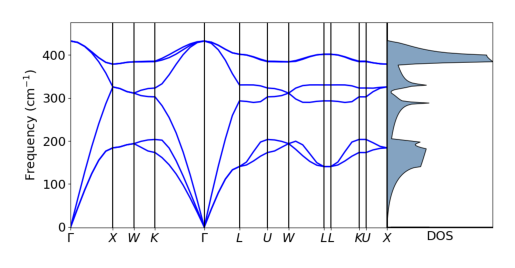

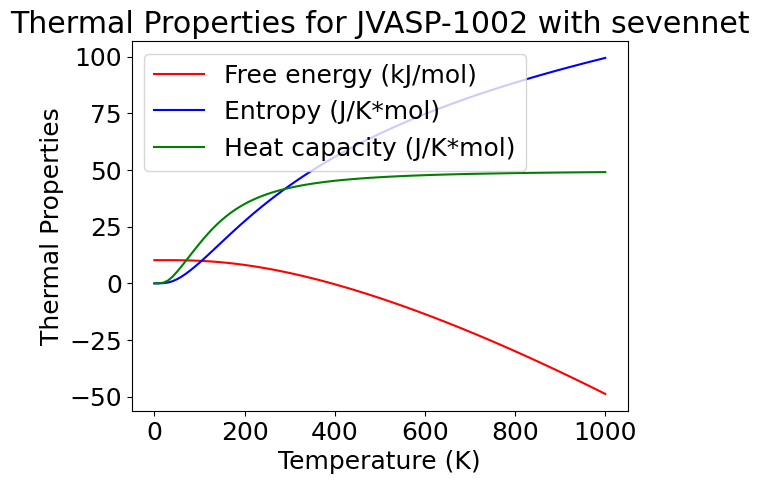

Zero-point energy for JVASP-1002 with sevennet: 0.10609908999030082 eV
Thermal Property Calculation time: 0.7169187068939209 seconds
Defect structure: JVASP-1002_Si_Si__Si
Final energy of FIRE optimization for defect structure: -338.022461
Defect relaxation converged within 200 steps.
Relaxed defect structure for JVASP-1002_Si_Si__Si: OrderedDict([('lattice_mat', [[10.987260280503339, -1.8242377691378734e-05, -2.614097852540852e-05], [-1.8242377691378734e-05, 10.987260127148357, -3.1165829844211e-05], [-2.614097852540852e-05, -3.1165829844211e-05, 10.987259592348364]]), ('coords', [[1.3733842707863841, 4.1202007584547085, 6.867022337904796], [1.3733883258267923, 9.613846482131521, 1.3733768840825913], [1.3733752302706557, 9.61383073125803, 6.867006691611677], [6.86702757109825, 4.120207254969128, 1.3733794398519208], [6.8670145685625075, 4.120191637281283, 6.867009260391438], [6.8670183092028765, 9.613837122659646, 1.373363801364384], [6.867005279846759, 9.613821768205037, 6.8669935920

In [ ]:
import os
import time
import matplotlib.pyplot as plt
from jarvis.analysis.defects.vacancy import Vacancy
from jarvis.analysis.defects.surface import Surface
from jarvis.core.atoms import Atoms, get_supercell_dims
from jarvis.analysis.structure.spacegroup import (
    Spacegroup3D,
    symmetrically_distinct_miller_indices,
)
from alignn.ff.ff import phonons
from alignn.ff.ff import phonons3
model_path = default_path()
#calculator_types = ["matgl","chgnet","alignn_ff","mace","sevennet"]

ids = ['JVASP-1002']
calculator_types = ["sevennet"]

%matplotlib inline
for calculator_type in calculator_types:
    for jid in ids:
        output_dir = f"{jid}_{calculator_type}"
        os.makedirs(output_dir, exist_ok=True)
        log_file = os.path.join(output_dir, f"{jid}_{calculator_type}_job_log.txt")

        log_job_info(f"Processing with calculator: {calculator_type}", log_file)

        calculator = setup_calculator(calculator_type)
        job_info = {"jid": jid, "calculator_type": calculator_type}

        atoms = get_atoms(jid)
        log_job_info(f'Initial atoms for {jid}: {atoms.to_dict()}', log_file)
        job_info["initial_atoms"] = atoms.to_dict()

        job_info_filename = os.path.join(output_dir, f"{jid}_{calculator_type}_job_info.json")
        save_dict_to_json(job_info, job_info_filename)

        start_time = time.time()
        relaxed_atoms = relax_structure(atoms, calculator_type, log_file=log_file, job_info=job_info)
        log_job_info(f'Relaxed structure for {jid}: {relaxed_atoms.to_dict()}', log_file)
        job_info["relaxed_atoms"] = relaxed_atoms.to_dict()

        save_dict_to_json(job_info, job_info_filename)
        end_time = time.time()
        log_job_info(f"Relaxation time: {end_time - start_time} seconds", log_file)


        poscar = Poscar(atoms=relaxed_atoms)
        poscar_filename = os.path.join(output_dir, f'POSCAR_{jid}_relaxed_{calculator_type}.vasp')
        poscar.write_file(poscar_filename)
        job_info["poscar_relaxed"] = poscar_filename

        start_time = time.time()
        x, y, eos, kv, e0, v0 = calculate_ev_curve(relaxed_atoms, calculator)
        log_job_info(f"Bulk modulus for {jid}: {kv} GPa", log_file)
        log_job_info(f"Equilibrium energy for {jid}: {e0} eV", log_file)
        log_job_info(f"Equilibrium volume for {jid}: {v0} Å³", log_file)
        job_info["bulk_modulus"] = kv
        job_info["equilibrium_energy"] = e0
        job_info["equilibrium_volume"] = v0
        job_info["eos_data"] = {"x": x.tolist(), "y": y.tolist()}


        fig = plt.figure()
        eos.plot()
        eos_plot_filename = os.path.join(output_dir, f"E_vs_V_{jid}_{calculator_type}.png")
        fig.savefig(eos_plot_filename)
        plt.close(fig)
        log_job_info(f"EV curve plot saved to {eos_plot_filename}", log_file)
        job_info["eos_plot"] = eos_plot_filename

        save_dict_to_json(job_info, job_info_filename)
        end_time = time.time()
        log_job_info(f"EV Curve time: {end_time - start_time} seconds", log_file)
        formation_energy_per_atom = calculate_formation_energy_per_atom(e0, relaxed_atoms, calculator_type)
        log_job_info(f"Formation energy per atom for {jid}: {formation_energy_per_atom} eV/atom", log_file)
        job_info["formation_energy_per_atom"] = formation_energy_per_atom

        start_time = time.time()
        elastic_tensor = calculate_elastic_tensor(atoms=relaxed_atoms, calculator=setup_calculator(calculator_type))
        job_info["elastic_tensor"] = elastic_tensor
        log_job_info(f"Elastic tensor for {jid} with {calculator_type}: {elastic_tensor}", log_file)
        end_time = time.time()
        log_job_info(f"Elastic Calculation time: {end_time - start_time} seconds", log_file)

        save_dict_to_json(job_info, job_info_filename)
        phonopy_bands_figname = os.path.join(output_dir, f"ph_{jid}_{calculator_type}.png")
        if calculator_type == "alignn_ff":
            start_time = time.time()
            phonon = phonons(model_path=model_path, atoms=relaxed_atoms, phonopy_bands_figname=phonopy_bands_figname, force_mult_natoms=True)
            end_time = time.time()
            log_job_info(f"Phonon Calculation time: {end_time - start_time} seconds", log_file)
        else:
            start_time = time.time()
            phonon = phonons_gen(atoms=relaxed_atoms, phonopy_bands_figname=phonopy_bands_figname, calculator=setup_calculator(calculator_type))
            end_time = time.time()
            log_job_info(f"Phonon Calculation time: {end_time - start_time} seconds", log_file)

        plt.figure()
        plt.axis('off')
        plt.imshow(plt.imread(phonopy_bands_figname))
        plt.show()
        plt.close()
        job_info["phonopy_bands"] = phonopy_bands_figname


        save_dict_to_json(job_info, job_info_filename)
        start_time = time.time()
        phonon.run_mesh(mesh=[20, 20, 20])
        phonon.run_thermal_properties(t_step=10, t_max=1000, t_min=0)
        tprop_dict = phonon.get_thermal_properties_dict()

        plt.figure()
        plt.plot(tprop_dict['temperatures'], tprop_dict['free_energy'], label='Free energy (kJ/mol)', color='red')
        plt.plot(tprop_dict['temperatures'], tprop_dict['entropy'], label='Entropy (J/K*mol)', color='blue')
        plt.plot(tprop_dict['temperatures'], tprop_dict['heat_capacity'], label='Heat capacity (J/K*mol)', color='green')
        plt.legend()
        plt.xlabel('Temperature (K)')
        plt.ylabel('Thermal Properties')
        plt.title(f'Thermal Properties for {jid} with {calculator_type}')
        thermal_props_plot_filename = os.path.join(output_dir, f"Thermal_Properties_{jid}_{calculator_type}.png")
        plt.savefig(thermal_props_plot_filename)
        plt.show()
        job_info["thermal_properties_plot"] = thermal_props_plot_filename

        zpe = tprop_dict['free_energy'][0] * 0.0103643  # converting from kJ/mol to eV
        log_job_info(f"Zero-point energy for {jid} with {calculator_type}: {zpe} eV", log_file)
        job_info["zero_point_energy"] = zpe
        end_time = time.time()
        log_job_info(f"Thermal Property Calculation time: {end_time - start_time} seconds", log_file)
        save_dict_to_json(job_info, job_info_filename)
        if calculator_type == "alignn_ff":
            kappa = phonons3(model_path=model_path, atoms=relaxed_atoms)
        else:
            kappa = phonons3_gen(atoms=relaxed_atoms, calculator=calculator,output_dir=output_dir)

        move_hdf5_files(output_dir)
        process_phonon3_results(output_dir, log_file, job_info)
        save_dict_to_json(job_info, job_info_filename)


        strts = Vacancy(atoms).generate_defects(on_conventional_cell=True, enforce_c_size=8, extend=1)
        for j in strts:
            strt = Atoms.from_dict(j.to_dict()['defect_structure'])
            name = f"{jid}_{strt.composition.reduced_formula}_{j.to_dict()['symbol']}_{j.to_dict()['wyckoff_multiplicity']}"
            log_job_info(f'Defect structure: {name}', log_file)
            pos = Poscar(strt)
            pos.write_file(os.path.join(output_dir, f"POSCAR_{name}.vasp"))
            start_time = time.time()
            relaxed_defect_atoms = relax_defect_structure(strt, calculator_type, log_file=log_file, job_info=job_info)
            log_job_info(f"Relaxed defect structure for {name}: {relaxed_defect_atoms.to_dict()}", log_file)
            job_info[f"Relaxed defect structure for {name}"] = relaxed_defect_atoms.to_dict()
            save_dict_to_json(job_info, job_info_filename)
            end_time = time.time()
            log_job_info(f"Defect Relaxation Calculation time: {end_time - start_time} seconds", log_file)
            pos_relaxed = Poscar(relaxed_defect_atoms)
            pos_relaxed.write_file(os.path.join(output_dir, f"POSCAR_{name}_relaxed_{calculator_type}.vasp"))


            vacancy_energy = job_info[f"final_energy_defect for {name}"]
            bulk_energy = job_info["equilibrium_energy"]/atoms.num_atoms * (relaxed_defect_atoms.num_atoms + 1)
            element = j.to_dict()["symbol"]
            chemical_potential = get_chemical_potential(element, calculator_type)
            vacancy_formation_energy = vacancy_energy - bulk_energy + chemical_potential
            log_job_info(f"Vacancy formation energy for {name}: {vacancy_formation_energy} eV", log_file)
            job_info[f"vacancy_formation_energy for {name}"] = vacancy_formation_energy
        save_dict_to_json(job_info, job_info_filename)


        for indices in indices_list:
            surface = Surface(atoms=atoms, indices=indices, layers=4, vacuum=18).make_surface().center_around_origin()
            if surface.check_polar:
                log_job_info(f"Skipping polar surface for {jid} with indices {indices}", log_file)
                continue
            poscar_surface = Poscar(atoms=surface)
            poscar_surface.write_file(os.path.join(output_dir, f"POSCAR_{jid}_surface_{indices}_{calculator_type}.vasp"))
            start_time = time.time()
            relaxed_surface_atoms = relax_surface_structure(surface, calculator_type, log_file=log_file, job_info=job_info)
            log_job_info(f"Relaxed surface structure for {jid} with indices {indices}: {relaxed_surface_atoms.to_dict()}", log_file)
            job_info[f"Relaxed surface structure for {jid} with indices {indices}"] = relaxed_surface_atoms.to_dict()
            end_time = time.time()
            log_job_info(f"Surface Relaxation Calculation time: {end_time - start_time} seconds", log_file)
            save_dict_to_json(job_info, job_info_filename)

            pos_relaxed_surface = Poscar(relaxed_surface_atoms)
            m = relaxed_surface_atoms.lattice.matrix
            surface_area = np.linalg.norm(np.cross(m[0], m[1]))

            pos_relaxed_surface.write_file(os.path.join(output_dir, f"POSCAR_{jid}_surface_{indices}_{calculator_type}_relaxed.vasp"))

            save_dict_to_json(job_info, job_info_filename)
            surface_energy = job_info.get(f"final_energy_surface for {jid} with indices {indices}")
            bulk_energy = job_info.get("equilibrium_energy")
            num_units = surface.num_atoms / atoms.num_atoms

            surf_energy = calculate_surface_energy(surface_energy, bulk_energy, num_units, surface_area)
            log_job_info(f"Surface energy for {jid} with indices {indices}: {surf_energy} J/m^2", log_file)
            job_info[f"surface_energy for {jid} with indices {indices}"] = surf_energy

        save_dict_to_json(job_info, job_info_filename)

        interface_scan_results, interface_scan_plot, w_adhesion, systems_info = perform_interface_scan(
            film_jid=jid,
            substrate_jid=jid,
            film_index="1_1_0",
            substrate_index="1_1_0",
            disp_intvl=0.05,
            calculator_method=calculator_type.lower(),
            output_dir=output_dir,
            log_file=log_file
        )
        if interface_scan_results:
            job_info["interface_scan_results"] = interface_scan_results
            log_job_info(f"Interface scan results saved to {interface_scan_results}", log_file)
        if interface_scan_plot:
            job_info["interface_scan_plot"] = interface_scan_plot
            log_job_info(f"Interface scan plot saved to {interface_scan_plot}", log_file)
        if w_adhesion:
            job_info["w_adhesion"] = w_adhesion
            log_job_info(f"w_adhesion: {w_adhesion}", log_file)
        if systems_info:
            job_info["systems_info"] = systems_info
            log_job_info(f"systems_info: {systems_info}", log_file)
        save_dict_to_json(job_info, job_info_filename)

        quenched_atoms = general_melter(jid=jid, atoms=relaxed_atoms, calculator=calculator, log_file=log_file, job_info=job_info, output_dir=output_dir)
        calculate_rdf(quenched_atoms.ase_converter(), jid, calculator_type, output_dir, log_file, job_info)
        save_dict_to_json(job_info, job_info_filename)
        condensed_results = {
            "calculator_type": calculator_type,
            "jid": jid,
            "relaxed_atoms": relaxed_atoms.to_dict(),
            "a": relaxed_atoms.lattice.a,
            "b": relaxed_atoms.lattice.b,
            "c": relaxed_atoms.lattice.c,
            "equilibrium_energy": e0,
            "equilibrium_volume": v0,
            "formation_energy_per_atom": formation_energy_per_atom,
            "bulk_modulus": kv,
            "zero_point_energy": zpe,
            "elastic_tensor": elastic_tensor,
            "vacancy_formation_energies": {k: v for k, v in job_info.items() if "vacancy_formation_energy" in k},
            "surface_energies": {k: v for k, v in job_info.items() if "surface_energy" in k}
        }

        condensed_results_filename = os.path.join(output_dir, f"{jid}_{calculator_type}_final_results.json")
        save_dict_to_json(condensed_results, condensed_results_filename)
        log_job_info(f"Final results saved to {condensed_results_filename}", log_file)
